In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/adil200/Medical-Diagnoser/main/medical_data.csv')
data.head()


,Patient_Problem,Disease,Prescription
0,"Constant fatigue and muscle weakness, struggli...",Chronic Fatigue Syndrome,"Cognitive behavioral therapy, graded exercise ..."
1,"Frequent severe migraines, sensitivity to ligh...",Migraine with Aura,"Prescription triptans, avoid triggers like bri..."
2,"Sudden weight gain and feeling cold, especiall...",Hypothyroidism,Levothyroxine to regulate thyroid hormone levels.
3,"High fever, sore throat, and swollen lymph nod...",Mononucleosis,"Rest and hydration, ibuprofen for pain."
4,"Excessive thirst and frequent urination, dry m...",Diabetes Mellitus,Insulin therapy and lifestyle changes.


In [3]:
# Display basic statistics
print(data.describe())


                                          Patient_Problem  \
count                                                 407   
unique                                                407   
top     Constant fatigue and muscle weakness, struggli...   
freq                                                    1   

                     Disease                          Prescription  
count                    407                                   407  
unique                   178                                   388  
top     Rheumatoid Arthritis  Thyroid hormone replacement therapy.  
freq                      14                                     6  


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Patient_Problem  407 non-null    object
 1   Disease          407 non-null    object
 2   Prescription     407 non-null    object
dtypes: object(3)
memory usage: 9.7+ KB
None


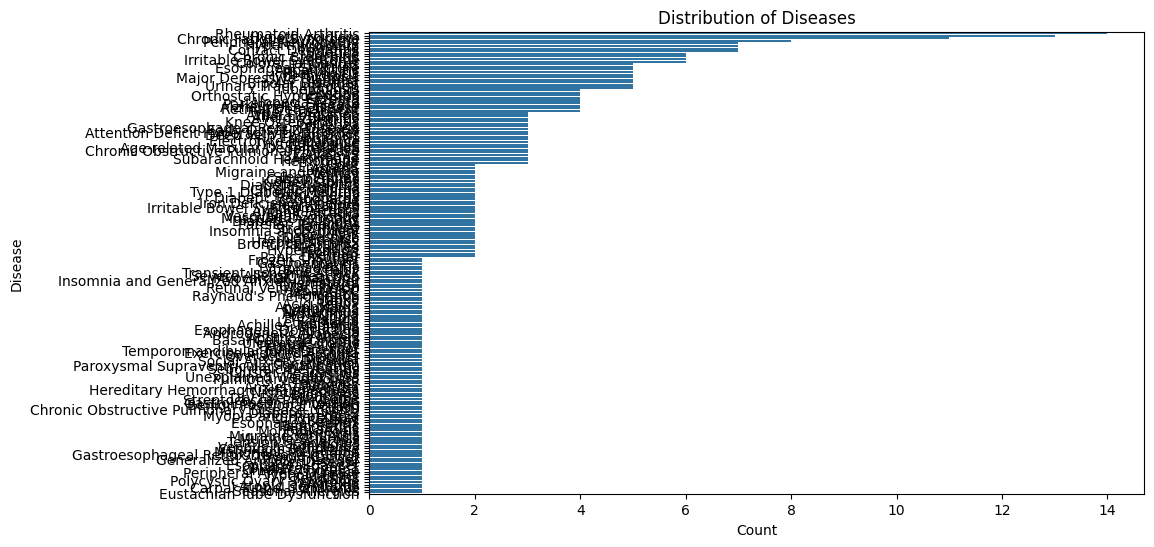

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of diseases
plt.figure(figsize=(10, 6))
sns.countplot(y=data['Disease'], order=data['Disease'].value_counts().index)
plt.title('Distribution of Diseases')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.show()


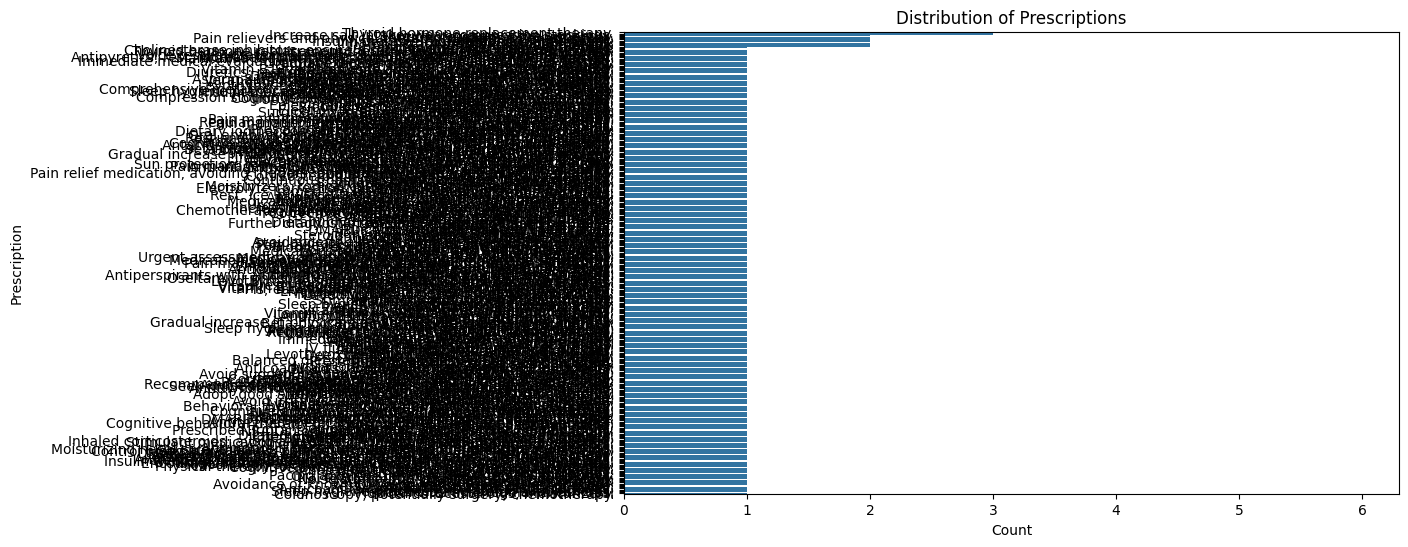

In [6]:
# Distribution of prescriptions
plt.figure(figsize=(10, 6))
sns.countplot(y=data['Prescription'], order=data['Prescription'].value_counts().index)
plt.title('Distribution of Prescriptions')
plt.xlabel('Count')
plt.ylabel('Prescription')
plt.show()

In [7]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['Patient_Problem'])
sequences = tokenizer.texts_to_sequences(data['Patient_Problem'])
max_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [8]:
# Encode the labels
label_encoder_disease = LabelEncoder()
label_encoder_prescription = LabelEncoder()
disease_labels = label_encoder_disease.fit_transform(data['Disease'])
prescription_labels = label_encoder_prescription.fit_transform(data['Prescription'])
disease_labels_categorical = to_categorical(disease_labels)
prescription_labels_categorical = to_categorical(prescription_labels)
Y = np.hstack((disease_labels_categorical, prescription_labels_categorical))


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, Y, test_size=0.2, random_state=42)
y_train_disease = y_train[:, :len(label_encoder_disease.classes_)]
y_train_prescription = y_train[:, len(label_encoder_disease.classes_):]
y_test_disease = y_test[:, :len(label_encoder_disease.classes_)]
y_test_prescription = y_test[:, len(label_encoder_disease.classes_):]


In [10]:
# Define the model
input_layer = Input(shape=(max_length,))
embedding = Embedding(input_dim=5000, output_dim=64)(input_layer)
lstm_layer = LSTM(64)(embedding)
dropout_layer = Dropout(0.5)(lstm_layer)  # Add Dropout

disease_output = Dense(len(label_encoder_disease.classes_), activation='softmax', name='disease_output')(dropout_layer)
prescription_output = Dense(len(label_encoder_prescription.classes_), activation='softmax', name='prescription_output')(dropout_layer)

model = Model(inputs=input_layer, outputs=[disease_output, prescription_output])
model.compile(
    loss={'disease_output': 'categorical_crossentropy', 'prescription_output': 'categorical_crossentropy'},
    optimizer='adam',
    metrics={'disease_output': ['accuracy'], 'prescription_output': ['accuracy']}
)


In [11]:
# Print the model summary
model.summary()

# Train the model
model.fit(
    X_train,
    {'disease_output': y_train_disease, 'prescription_output': y_train_prescription},
    epochs=100,
    batch_size=32
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 17)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 17, 64)               320000    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 64)                   33024     ['embedding[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 64)                   0         ['lstm[0][0]']                
                                                                                              

In [12]:
model.compile(
    loss={'disease_output': 'categorical_crossentropy', 'prescription_output': 'categorical_crossentropy'},
    optimizer='adam',
    metrics={'disease_output': ['accuracy'], 'prescription_output': ['accuracy']}
)


In [13]:
eval_results = model.evaluate(
    X_test,
    {'disease_output': y_test_disease, 'prescription_output': y_test_prescription}
)
print(eval_results)


3/3 [==============================] - 1s 5ms/step - loss: 16.5212 - disease_output_loss: 5.9749 - prescription_output_loss: 10.5464 - disease_output_accuracy: 0.1829 - prescription_output_accuracy: 0.0122
[16.521209716796875, 5.974852561950684, 10.546356201171875, 0.18292683362960815, 0.012195121496915817]


In [14]:
# Evaluate the model
eval_results = model.evaluate(
    X_test,
    {'disease_output': y_test_disease, 'prescription_output': y_test_prescription}
)

# Unpack results based on the actual output structure
if len(eval_results) == 3:
    loss, disease_accuracy, prescription_accuracy = eval_results
    print(f"Loss: {loss}")
    print(f"Disease Accuracy: {disease_accuracy}")
    print(f"Prescription Accuracy: {prescription_accuracy}")
else:
    print(f"Unexpected number of results: {len(eval_results)}")


3/3 [==============================] - 0s 4ms/step - loss: 16.5212 - disease_output_loss: 5.9749 - prescription_output_loss: 10.5464 - disease_output_accuracy: 0.1829 - prescription_output_accuracy: 0.0122
Unexpected number of results: 5


In [15]:
print(f"Number of disease classes: {len(label_encoder_disease.classes_)}")
print(f"Number of prescription classes: {len(label_encoder_prescription.classes_)}")


Number of disease classes: 178
Number of prescription classes: 388


In [17]:
# Confusion Matrices
y_pred = model.predict(X_test)
y_pred_disease = np.argmax(y_pred[0], axis=1)
y_pred_prescription = np.argmax(y_pred[1], axis=1)
cm_disease = confusion_matrix(np.argmax(y_test_disease, axis=1), y_pred_disease)
cm_prescription = confusion_matrix(np.argmax(y_test_prescription, axis=1), y_pred_prescription)


3/3 [==============================] - 0s 5ms/step


In [19]:
# Define prediction function
def make_prediction(patient_problem):
    sequence = tokenizer.texts_to_sequences([patient_problem])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = model.predict(padded_sequence)
    disease_index = np.argmax(prediction[0], axis=1)[0]
    prescription_index = np.argmax(prediction[1], axis=1)[0]
    disease_predicted = label_encoder_disease.inverse_transform([disease_index])[0]
    prescription_predicted = label_encoder_prescription.inverse_transform([prescription_index])[0]
    print(f"Predicted Disease: {disease_predicted}")
    print(f"Suggested Prescription: {prescription_predicted}")

In [20]:
# Example usage
patient_input = "I've experienced a loss of appetite and don't enjoy food anymore."
make_prediction(patient_input)

1/1 [==============================] - 0s 34ms/step
Predicted Disease: Hyperthyroidism
Suggested Prescription: Thyroid hormone replacement therapy.


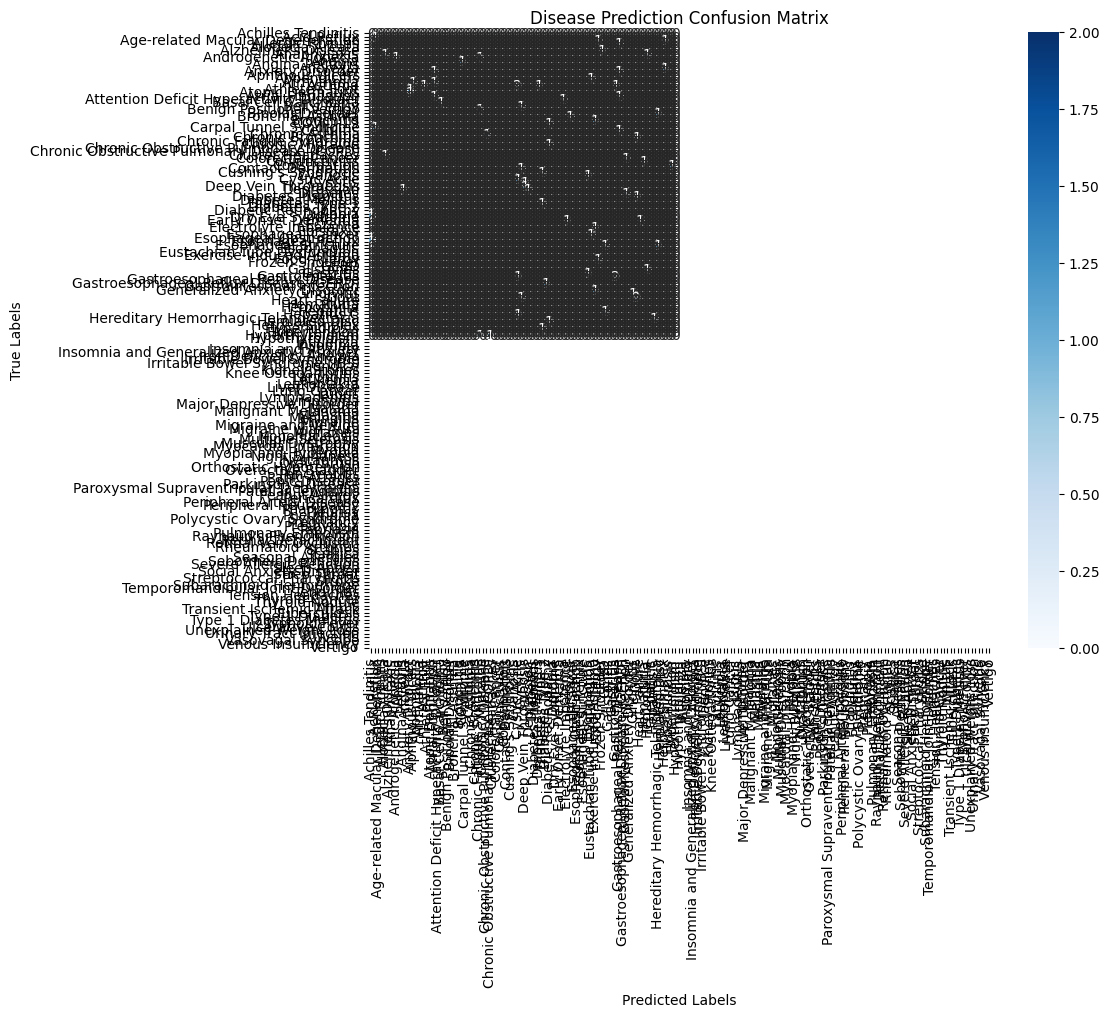

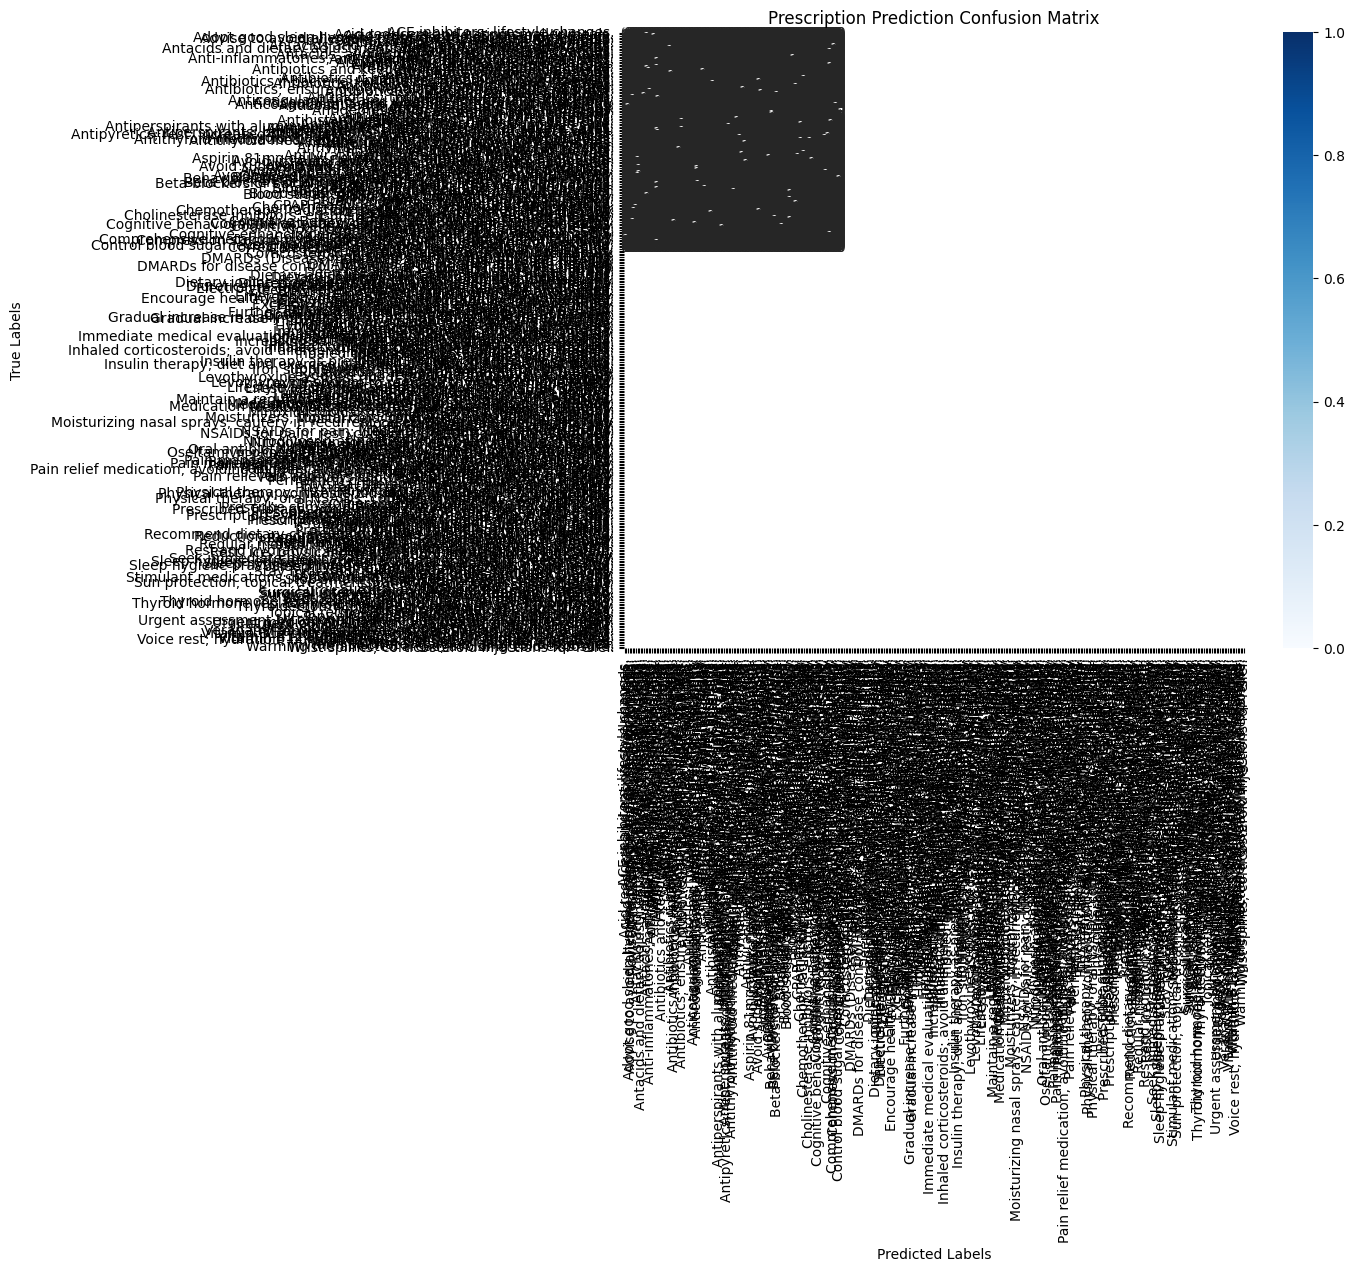

In [21]:
import seaborn as sns

def plot_confusion_matrix(conf_matrix, labels, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(cm_disease, label_encoder_disease.classes_, 'Disease Prediction Confusion Matrix')
plot_confusion_matrix(cm_prescription, label_encoder_prescription.classes_, 'Prescription Prediction Confusion Matrix')


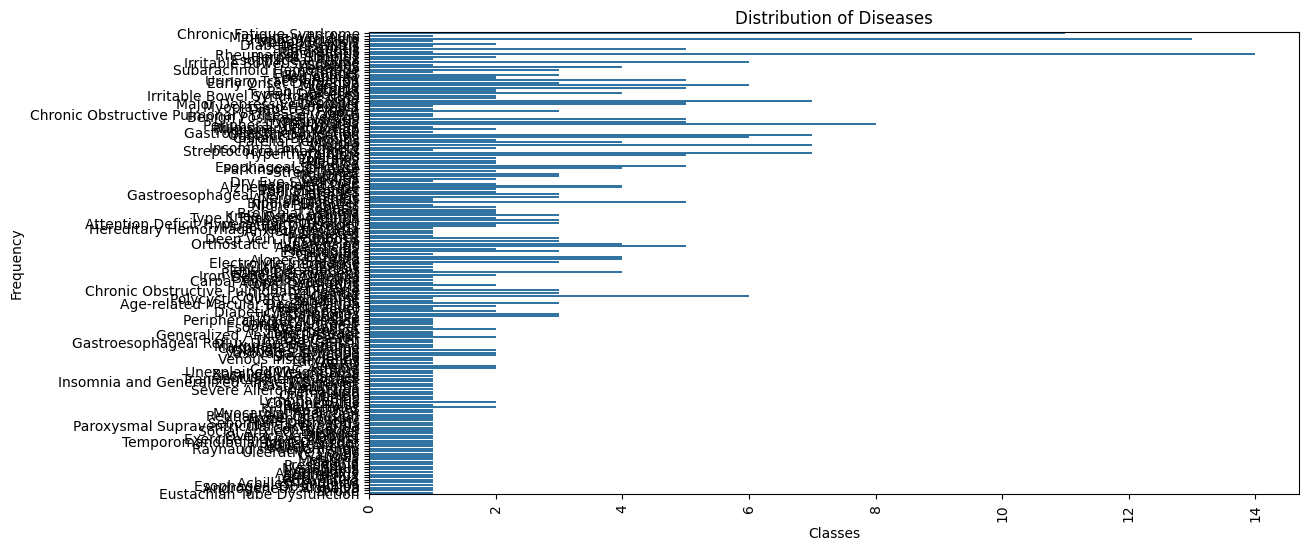

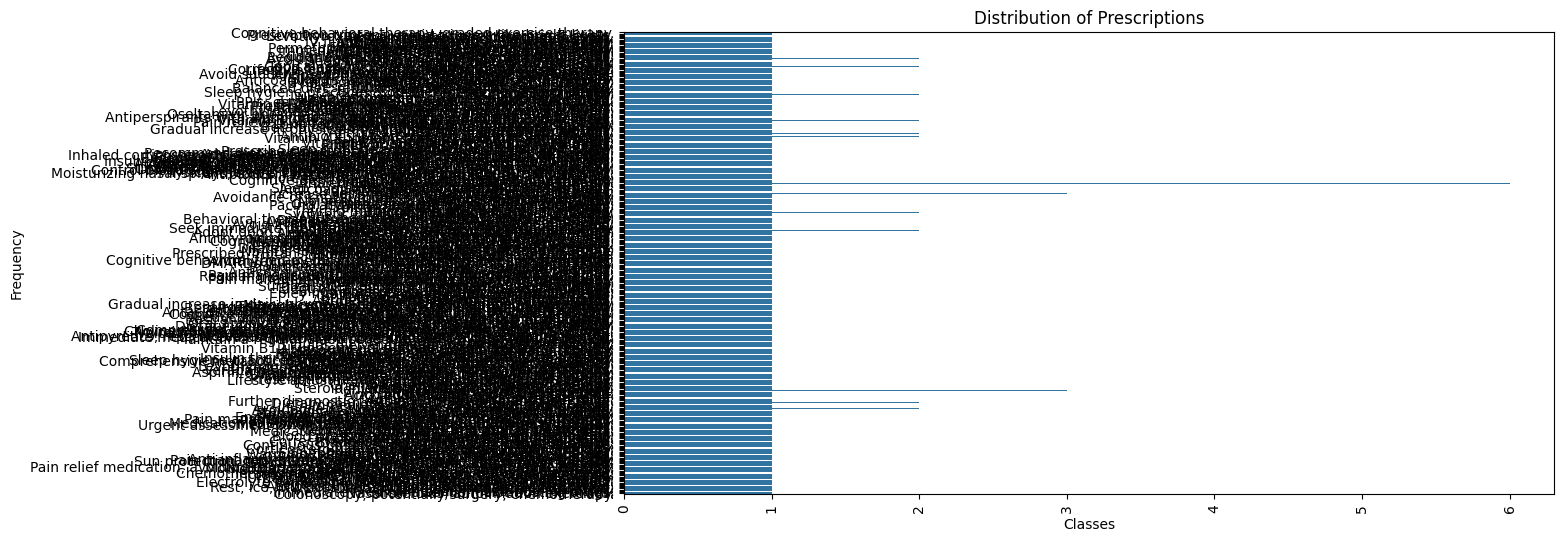

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_class_distribution(data, column_name, title):
    plt.figure(figsize=(12, 6))
    sns.countplot(data[column_name])
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Plot class distributions
plot_class_distribution(data, 'Disease', 'Distribution of Diseases')
plot_class_distribution(data, 'Prescription', 'Distribution of Prescriptions')
